In [1]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import requests, json
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import mapping
import shapely.speedups

plt.rcParams['figure.figsize'] = (15, 12)

In [2]:
# testing Ryan's gpd.read_file workaround for geojson

def remoteGeoJSONToGDF(url, display = False):
    r = requests.get(url)
    data = r.json()
    gdf = gpd.GeoDataFrame.from_features(data['features'])
    gdf.crs= {'init':'epsg:4326'} #suggestion from Lee
    if display:
        gdf.plot()
    return gdf

In [3]:
# import data
na_streams = remoteGeoJSONToGDF('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_10m_rivers_north_america.geojson')
us_states = gpd.read_file('data/cb_2017_us_state_20m')
# toxic data invetory from https://data.world/dhs/epa-er-toxic-release-inventory
toxic = pd.read_csv('https://query.data.world/s/3b3oi57gti4qhoexmg74sdc3ftz2te', index_col='FID')

In [4]:
print(na_streams.crs) #4326
print(us_states.crs) #4269

{'init': 'epsg:4326'}
{'init': 'epsg:4269'}


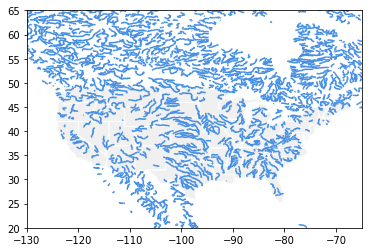

In [5]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#448ee4'

us_states.plot(ax=ax, edgecolor='white', color=base_color)
na_streams.plot(ax=ax, color=line_color, zorder=1);

ax.set(xlim=(-130,-65), ylim=(20,65));

In [6]:
us_states.geom_type.unique()

array(['MultiPolygon', 'Polygon'], dtype=object)

In [7]:
# create a single polygon object for clipping
us_poly = us_states.geometry.unary_union
# create a new GeoDataFrame by selecting the na_rails that intersect with the us_poly
us_streams = na_streams[na_streams.geometry.intersects(us_poly)]

In [8]:
# Create a single polygon object for clipping
us_poly = us_states.geometry.unary_union
streams_spatial_index = na_streams.sindex

# Create a box for the initial intersection
bbox = us_poly.bounds

# Get a list of id's for each road line that overlaps the bounding box 
# and subset the data to just those lines
sidx = list(streams_spatial_index.intersection(bbox))
streams_sub = na_streams.iloc[sidx]

# Clip the data - with these data
clipped = streams_sub.copy()
clipped['geometry'] = streams_sub.intersection(us_poly)

# clipped layer with no null geometry values
us_streams_cipped_2 = clipped[clipped.geometry.notnull()]

[(20, 65), (-130, -65)]

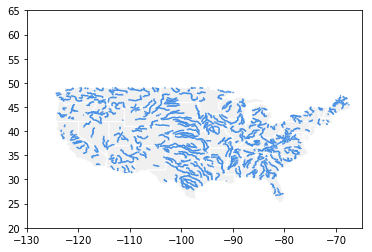

In [9]:
#initial map of rivers in the US
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#448ee4'

us_states.plot(ax=ax, edgecolor='white', color=base_color)
us_streams_cipped_2.plot(ax=ax, color=line_color, zorder=1);

ax.set(xlim=(-130,-65), ylim=(20,65))

In [10]:
# prepare toxic site data for mapping
geoms = [Point(xy) for xy in zip(toxic.X, toxic.Y)]
crs = {'init' :'epsg:4269'}
toxic = gpd.GeoDataFrame(toxic, crs=crs, geometry=geoms)

[(20, 65), (-130, -65)]

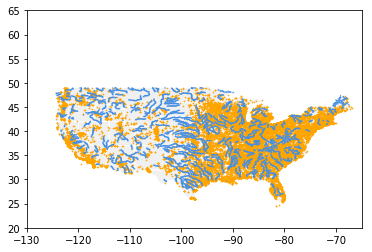

In [11]:
# map of rivers and toxic sites
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#448ee4'

us_states.plot(ax=ax, edgecolor='white', color=base_color);
toxic.plot(ax=ax, color='orange', zorder=1, markersize=.4);
us_streams_cipped_2.plot(ax=ax, color=line_color, zorder=2);

ax.set(xlim=(-130,-65), ylim=(20,65))

In [12]:
# update the projection

states_eqdc = us_states.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
toxic_eqdc = toxic.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
streams_eqdc = us_streams.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs ')

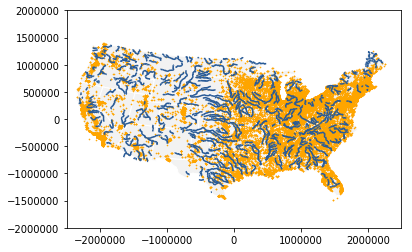

In [13]:
fig, ax = plt.subplots()

states_eqdc.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0);
toxic_eqdc.plot(ax=ax, color='orange', zorder=1, markersize=.4);
streams_eqdc.plot(ax=ax, color='#295b97', zorder=2);

ax.set(xlim=(-2500000,2500000), ylim=(-2000000,2000000));

In [14]:
# create a new column and assign it the result of the buffer operation
toxic_eqdc['buffer'] = toxic_eqdc.buffer(5000)
# not they are now polygons in meters
toxic_eqdc['buffer'].head()

FID
15001    POLYGON ((-2158933.28075505 -222375.0758693731...
15002    POLYGON ((1222182.379598539 404620.5482386216,...
15003    POLYGON ((1042349.944921823 367321.004635038, ...
15004    POLYGON ((-1594711.493149008 1160756.054234033...
15005    POLYGON ((1627499.468173632 9178.198860914015,...
Name: buffer, dtype: object

In [15]:
# the geometry column is still the geometry of the GeoDataFrame
print(toxic_eqdc.geometry.name)
# set the buffer column as the active geometry
toxic_eqdc = toxic_eqdc.set_geometry('buffer')
# now the geometry is the buffer column
print(toxic_eqdc.geometry.name)

geometry
buffer


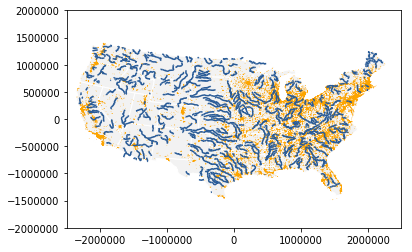

In [16]:
fig, ax = plt.subplots()

states_eqdc.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0);
toxic_eqdc.plot(ax=ax, color='orange', zorder=1, markersize=.4);
streams_eqdc.plot(ax=ax, color='#295b97', zorder=2);

ax.set(xlim=(-2500000,2500000), ylim=(-2000000,2000000));